### Here we are trying to build a system which will analyse the below 3 points of an essay parallely-
#### 1. Clarity of thoughts
#### 2. Depth of Analysis
#### 3. Language

### And then finally it will do a final evaluation

In [17]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq

from typing import TypedDict, Annotated
import operator
from dotenv import load_dotenv

from pydantic import BaseModel, Field

load_dotenv()

True

In [18]:
# Initialize Groq LLM
model = ChatGroq(model="llama-3.1-8b-instant")

### We want a structured output from our model , so we will define a schema to the LLM and update it to a structured model

In [19]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback of the essay")
    score: int = Field(description= "A score on 10 for the essay")

In [20]:
# Structured model
structured_model = model.with_structured_output(EvaluationSchema)

### Creating State and graph

In [21]:
class EssayScoringState(TypedDict):
    essay: str
    language_feedback: str
    clarity_feedback: str
    analysis_feedback: str
    overall_feedback: str
    individual_score: Annotated[list[int], operator.add]    ## add is a reducer function. Here we are taking the scores for each section as list of integer and then adding them into a list 
    avg_score: int

In [22]:
# Creating the node functions
def evaluate_language(state: EssayScoringState):
    prompt = f"""Evaluate the language of the essay \n {state['essay']} \n Now give 
                -feedback
                -score on 10"""
    response = structured_model.invoke(prompt)

    return {'language_feedback': response.feedback, 'individual_score':[response.score]}


def evaluate_thought(state: EssayScoringState):
    prompt = f"""Evaluate the clarity of thought of the essay \n {state['essay']} \n Now give 
                -feedback
                -score on 10"""
    response = structured_model.invoke(prompt)

    return {'clarity_feedback': response.feedback, 'individual_score':[response.score]}


def evaluate_analysis(state: EssayScoringState):
    prompt = f"""Evaluate the depth of analysis of the essay \n {state['essay']} \n Now give 
                -feedback
                -score on 10"""
    response = structured_model.invoke(prompt)

    return {'analysis_feedback': response.feedback, 'individual_score':[response.score]}


def final_evaluation(state: EssayScoringState):
    """
    Here we do not need the structured LLM as we will do the final evaluation.
    """
    prompt = f"""Based on the below feedback, create a summarized feedback-
                {state['analysis_feedback']}\n {state['clarity_feedback']}\n {state['language_feedback']}
                """
    overall_feedback = model.invoke(prompt)
    
    avg_score = sum(state['individual_score'])/len(state['individual_score'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

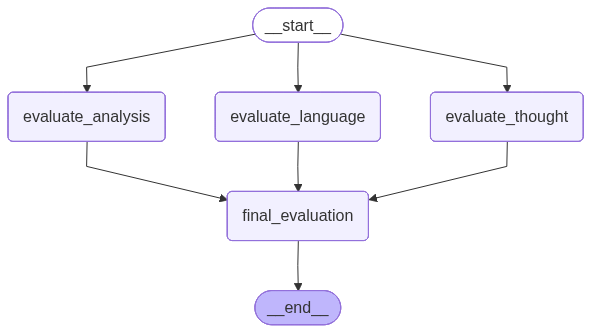

In [23]:
# graphs
graph = StateGraph(EssayScoringState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('final_evaluation', final_evaluation)

graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_thought')
graph.add_edge(START, 'evaluate_analysis')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()

workflow


In [24]:
## Executing workflow
initial_state = {'essay': """India is on the high road to economic growth. Since 2020, the world economy has declined due to the COVID-19 pandemic. Repeated waves of infection, supply-chain disruptions and inflation have created challenging times. Faced with these challenges, the Government of India has taken immediate action so that it has the least impact on the Indian economy.
The Indian economy has been staging a sustained recovery since the second half of 2020-21. However, the second wave of the pandemic in April-June 2021 was more severe from a health perspective. The national lockdown has affected small businesses, common people and everyone in India. Due to this, the Indian economy has gone down. But now, it is slowly rising up and taking its form."""
}

final_state = workflow.invoke(initial_state)

print(final_state)

{'essay': 'India is on the high road to economic growth. Since 2020, the world economy has declined due to the COVID-19 pandemic. Repeated waves of infection, supply-chain disruptions and inflation have created challenging times. Faced with these challenges, the Government of India has taken immediate action so that it has the least impact on the Indian economy.\nThe Indian economy has been staging a sustained recovery since the second half of 2020-21. However, the second wave of the pandemic in April-June 2021 was more severe from a health perspective. The national lockdown has affected small businesses, common people and everyone in India. Due to this, the Indian economy has gone down. But now, it is slowly rising up and taking its form.', 'language_feedback': "The essay provides a good overview of the Indian economy's challenges and recovery. However, it lacks depth and specific examples to support the arguments. The writing is clear, but the structure could be improved for better f

In [27]:
print(f"Overall feedback- {final_state['overall_feedback'].content}\n\n")
print(f"Individual Score- {final_state['individual_score']}")
print(f"Average Score- {final_state['avg_score']}")

Overall feedback- Here's a summarized feedback:

**Strengths:**

- The writer demonstrates a good understanding of the economic situation in India.
- The writing is clear, and there is clarity of thought.
- The essay provides a good overview of the Indian economy's challenges and recovery.

**Weaknesses:**

- The essay lacks in-depth analysis and specific examples to support claims.
- There are grammatical errors and lack of coherence in some parts.
- The structure of the essay could be improved for better flow and logical connection between points.


Individual Score- [6, 7, 7]
Average Score- 6.666666666666667
